In [5]:
%env CUDA_VISIBLE_DEVICES=3
%env OMP_NUM_THREADS=48
#^--change this
import os, sys, time
sys.path.insert(0, '..')
import faiss
import lib
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
from qhoptim.pyt import QHAdam
from functools import partial
device_ids = list(range(torch.cuda.device_count()))

experiment_name = 'deep1m_unq_4b'
experiment_name = '{}_{}.{:0>2d}.{:0>2d}_{:0>2d}:{:0>2d}:{:0>2d}'.format(experiment_name, *time.gmtime()[:6])
print("experiment:", experiment_name)

env: CUDA_VISIBLE_DEVICES=3
env: OMP_NUM_THREADS=48
experiment: deep1m_unq_4b_2020.11.09_07:08:02


### Description

This experiment trains UNQ model with 8-byte encoding on DEEP1M dataset and standard model size.

The original experiment was trained on 4 Nnvdia 1080 gtx GPUs. One can set arbitrary number of GPUs by changing the `CUDA_VISIBLE_DEVICES` variable at the top. This experiment may also consume around 8Gb of GPU memory. If one doesn't have this much memory, there are ways to reduce memory usage at the cost of training or inference speed.

1. Split data into smaller chunks. One can reduce `batch_size` parameter in `LearnedSimilaritySearch` and call lib.free_memory() after every memory-intensive operation. Use virtual batching: change `trainer.train_on_batch` below to:
```(python3.5)
model.train(True)
trainer.opt.zero_grad()
for chunk_start in range(0, len(x_batch), 1000):
    chunk = slice(chunk_start, chunk_start + 1000)
    metrics_t = model.compute_loss(x_batch[chunk], 
        sample_uniform(train_base, nearest_ids[chunk]),
        sample_uniform(train_base, negative_ids[chunk])
    )
    metrics_t['loss'].mean().backward()
trainer.opt.step()
trainer.step += 1
...
```
2. Reduce __batch_size__ in the __iterate_minibatches__ function - this will significantly reduce memory requirements but may reduce the resulting recall. Please also consider reducing `learning_rate_base` and `increasing warmup_steps` in the optimizer.
3. If you're low on CPU (we had 56), neighbor lookup will take up a lot of time. Set `rerank_k=float('inf')` - this will cause nearest neighbors to be computed with less memory-hungry implementation of FAISSFlatIndex. Please note that this will cause __overestimation__ of recall. Do not use this for comparison with other models.  

By default, this notebook trains a model that reranks 500 most promising candidates during nearest neighbor search. You can increase this number to boost recall across all regions. In order to do so, go to Trainer initialization below and change `rerank_k` in LearnedSimilaritySearch from 500 to a greater value.

In [6]:
dataset = lib.Dataset('DEEP1M', normalize=True)

model = lib.UNQModel(
    input_dim=dataset.vector_dim, hidden_dim=1024, bottleneck_dim=256,
    encoder_layers=2, decoder_layers=2, Activation=nn.ReLU,
    num_codebooks=4, codebook_size=256, initial_entropy=3.0,
    share_codewords=True
).cuda()

with torch.no_grad():
    model(dataset.train_vectors[:1000].cuda())
    # ^-- initialize model on first run

trainer = lib.Trainer(
    model=model, experiment_name=experiment_name, verbose=True,
    Loss=lib.TripletLoss, loss_opts=dict(
        reconstruction_distance=lib.DISTANCES['euclidian_squared'],
        reconstruction_coeff=1.0, triplet_coeff=0.01, triplet_delta=0.1,
        cv_coeff=0.1, square_cv=True,
    ),
    optimizer=lib.OneCycleSchedule(
        QHAdam(model.parameters(), nus=(0.8, 0.7), betas=(0.95, 0.998)), 
        learning_rate_base=1e-3, warmup_steps=10000, decay_rate=0.2),
    max_norm=10,
    
    LearnedSimilaritySearch=partial(lib.UNQSearch, model=model, rerank_k=500, batch_size=1000,
                                    reorder_batch_size=250, device_ids=device_ids),
    NegativeSimilaritySearch=partial(lib.UNQSearch, model=model, rerank_k=1, batch_size=1000,
                                    reorder_batch_size=250, device_ids=device_ids),
    SimilaritySearch=lib.FAISSFlatIndex,  # reference nearest vectors will be mined this way
    device_ids=device_ids
    
)

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
from tqdm import tqdm
from pandas import DataFrame
moving_average = lambda x, **kw: DataFrame({'x':np.asarray(x)}).x.ewm(**kw).mean().values

best_recall = 0.0
step_history, loss_history, recall_history = [], [], []

train_base = dataset.train_vectors.cuda()
train_gt = trainer.get_true_nearest_ids(train_base, k=10, exclude_self=True)

def fetch_negatives():
    return trainer.get_negative_ids(train_base.cpu(), positive_ids=train_gt.cpu(), k=100, skip_k=100).cuda()

def sample_uniform(base, ids):
    return base[ids[torch.arange(ids.shape[0]), torch.randint(0, ids.shape[1], size=[ids.shape[0]])]]

Computing ground truth neighbors... Done


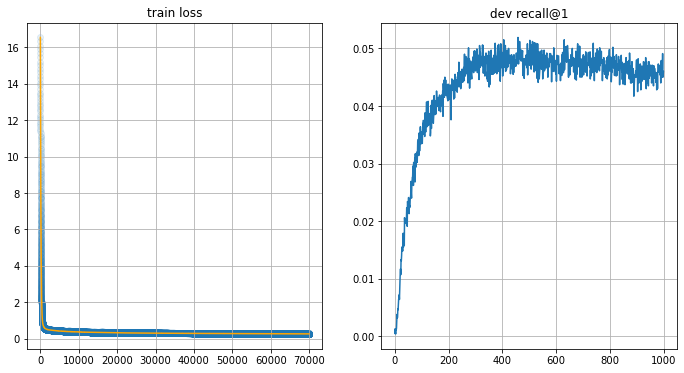

step = 69937 	 mean loss = 0.26778 	 lr = 0.00030 	 best dev recall = 0.05190
loss = 0.2869357466697693
reconstruction_loss = 0.265356183052063
triplet_loss = 0.20478689670562744
reg = 0.01953168399631977
cv_squared = 0.06495404988527298
grad_norm = 0.14222289621829987


100%|██████████| 7/7 [00:01<00:00,  6.95it/s]


Computing negative candidates... Done


100%|██████████| 7/7 [00:00<00:00,  7.71it/s]


In [8]:
for epoch_i in range(10000):
    trainer.loss.module.opts['cv_coeff'] = max(0.05, 1. - trainer.step / 100_000)
    trainer.drop_large_grads = trainer.step >= 1000
    
    lib.free_memory()
    if epoch_i % 8 == 0: # every ~250 steps
        train_negatives = fetch_negatives()
    
    for x_batch, nearest_ids, negative_ids in lib.iterate_minibatches(
        train_base, train_gt, train_negatives, batch_size=8192 * 2, callback=tqdm):
        metrics_t = trainer.train_on_batch(x_batch,
                                           x_positives=sample_uniform(train_base, nearest_ids),
                                           x_negatives=sample_uniform(train_base, negative_ids))
        loss_history.append(metrics_t['loss'].mean().item())
        step_history.append(trainer.step)
    
    if epoch_i % 10 == 0: # every ~500 steps
        metrics_t = {key: lib.check_numpy(value) for key, value in metrics_t.items()}
        lib.free_memory()
        
        recall_t = trainer.evaluate_recall(dataset.test_vectors.cuda(), dataset.query_vectors.cuda(), dataset.gt_vectors, k=1)
        # ^-- this line evaluates recall@1. Change k to 10, 100, etc. to get recall for different top sizes
        
        recall_history.append(recall_t)
        if recall_t > best_recall:
            best_recall = recall_t
            trainer.save_checkpoint('best')

        clear_output(True)
        plt.figure(figsize=[18, 6])
        plt.subplot(1, 3, 1); plt.title('train loss'); plt.grid()
        plt.scatter(step_history, loss_history, alpha=0.1)
        plt.plot(moving_average(loss_history, span=100), c='orange')
        plt.subplot(1, 3, 2); plt.title('dev recall@1'); plt.grid()
        plt.plot(recall_history)
        plt.show()

        print("step = %i \t mean loss = %.5f \t lr = %.5f \t best dev recall = %.5f" % (
            trainer.step, np.mean(loss_history[-100:]),
            lib.get_learning_rate(trainer.opt), best_recall))
        for k, v in metrics_t.items():
            print('{} = {}'.format(k, np.mean(lib.check_numpy(v))))

# see you in tensorboard...